# ID2222 Data Mining - Homework 3

Notebook by Beatrice Insalata, Laura Puccioni

This homework is based on the paper "TRIÈST: Counting Local and Global Triangles in Fully-Dynamic Streams with Fixed Memory Size". The paper presents a suite of one-pass streaming algorithms to compute unbiased, low-variance, high-quality approximations of the global and local number of triangles in fully dynamic graphs represented as an adversarial stream of edge insertions and deletions.

## Dataset
The dataset we decided to use for this task is "facebook_combined.txt", which consists of circles (or friends lists) from Facebook. It is an undirected graph containing a total of 4039 nodes and 88234 edges.

In [2]:
file_path = 'facebook_combined.txt'

edges = set()

try:
    with open(file_path, 'r') as file:
        for line in file:
            if '#' in line: #Skip the comment lines
                continue
            else:
                edge = tuple(line.replace("\n","").split(" "))
                edges.add(edge)
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

An example of 10 lines of the dataset can be seen below. Each tuple represents an edge between two nodes.

In [3]:
for i in range(0,10):
    print(list(edges)[i])

('1577', '2649')
('1199', '1658')
('3577', '3721')
('2068', '2169')
('2328', '2592')
('1462', '1628')
('1684', '3005')
('2161', '2396')
('2184', '2216')
('1221', '1462')


## TRIÈST Algorithm
The paper analysed presents two versions of the Trièst Algorithm, a basic one and an improved one for higher-quality estimations. The implementation of both algorithms can be found below.

### Trièst Algorithm - Basic Version
The class Triest_base contains functions that are needed to run the basic version of the algorithm:
- The 'sample_edge' function is the one designated to the decision of whether to insert or not a new sample. If the limit M of possible edges present in the edge sample S has not been reached yet (t<=M), the new edge is inserted. Otherwise (t>M), a biased coin with heads probability M/t is flipped:
    - If the outcome is heads, an edge (w,s) ∈ S is chosen uniformly at random and is removed from S, while the new edge is inserted in S.
    - If the outcome is tail, S is not modified.
- The 'update_counters' function is responsible for counting the number of triangles, updating both the global counter and the local counters of the new nodes and their neighbours.
- The function 'get_common_neighbourhood', is the one returning the common neighbours of the new edge.
- The 'run' function is the one responsible for running the algorithm on a dataset.

In [4]:
import random
import operator

class Triest_base():
    def __init__(self, M):
        self.S = set()
        self.t = 0
        self.tau = 0
        self.tau_count = {}
        self.M = M

    def sampleEdge(self,edge):
        if self.t<=self.M:
            return True
        elif random.random() < (self.M / self.t):
            random_edge = random.choice(tuple(self.S))
            self.S.remove(random_edge)
            self.updateCounters(operator.sub, random_edge)
            return True
        else:
            return False

    def updateCounters(self,operator,edge):
        u=edge[0]
        v=edge[1]

        common_neighbours = self.get_common_neighbours(edge)

        for c in common_neighbours:
            self.tau = operator(self.tau,1)
            self.tau_count[c] = operator(int(self.tau_count.get(c) or 0),1)
            self.tau_count[u] = operator(int(self.tau_count.get(u) or 0),1)
            self.tau_count[v] = operator(int(self.tau_count.get(v) or 0),1)

    def get_common_neighbours(self, edge):
        u=edge[0]
        v=edge[1]

        neighbours_u = set()
        neighbours_v = set()

        for elem in self.S:
            if u == elem[0]:
                neighbours_u.add(elem[1])
            if u == elem[1]:
                neighbours_u.add(elem[0])
            if v == elem[0]:
                neighbours_v.add(elem[1])
            if v == elem[1]:
                neighbours_v.add(elem[0])

        return neighbours_v & neighbours_u

    def run(self, dataset):
        for edge in dataset:
            #print(edge)
            self.t = self.t + 1
            if self.t % 5000 == 0:
                print("t:",self.t,"tau:",self.tau)
            if self.sampleEdge(edge):
                self.S.add(edge)
                #print(self.S)
                self.updateCounters(operator.add,edge)

        eps = (self.t*(self.t-1)*(self.t-2))/(self.M*(self.M-1)*(self.M-2))

        if eps < 1:
            eps = 1

        return self.tau*eps


To understand if the algorithm works properly, we can try it on a small graph. We can start with the following undirected graph:

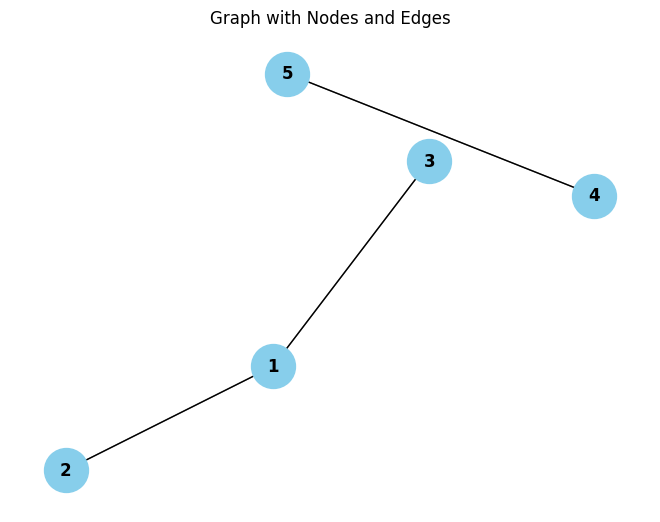

In [5]:
from matplotlib import pyplot as plt
import networkx as nx

example_graph = {(1,2), (3,1), (4,5)}
G = nx.Graph()
# Add nodes
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_node(5)

# Add edges
G.add_edge(1, 2)
G.add_edge(3, 1)
G.add_edge(4, 5)

k_value = 1.5  # Adjust this value to your preference
pos = nx.spring_layout(G, k=k_value)
nx.draw(G, pos, with_labels=True, node_color='skyblue', font_weight='bold', node_size=1000, font_size=12)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='black')

# Show the graph
plt.title("Graph with Nodes and Edges")
plt.axis('off')  # Disable axis display
plt.show()

We can see that there are no triangles, therefore our algorithm correctly returns 0 as the number of triangles in the graph:

In [6]:
base = Triest_base(3)
print("The estimated number of triangles estimated is:", base.run(example_graph))

The estimated number of triangles estimated is: 0.0


We keep trying with new nodes and new edges, to be sure that the algorithm works properly.

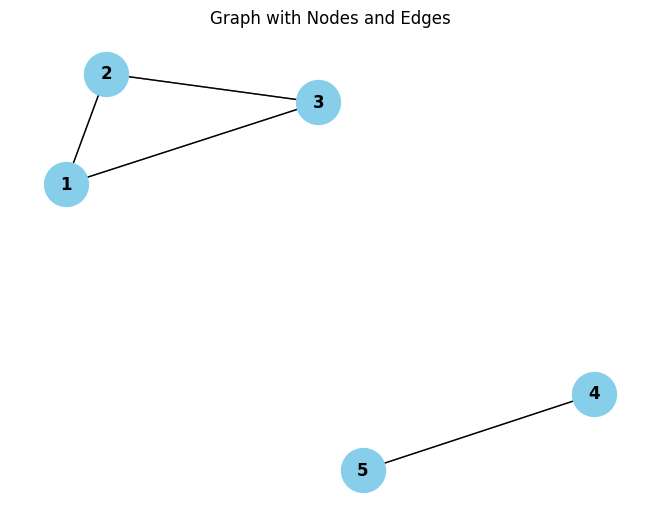

In [7]:
example_graph = {(1,2), (3,2), (3,1), (4,5)}
G = nx.Graph()
# Add nodes
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_node(5)

# Add edges
G.add_edge(1, 2)
G.add_edge(3, 2)
G.add_edge(3, 1)
G.add_edge(4, 5)

k_value = 1.5  # Adjust this value to your preference
pos = nx.spring_layout(G, k=k_value)
nx.draw(G, pos, with_labels=True, node_color='skyblue', font_weight='bold', node_size=1000, font_size=12)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='black')

# Show the graph
plt.title("Graph with Nodes and Edges")
plt.axis('off')  # Disable axis display
plt.show()

Given this graph and M = 4 = #edges, our algorithm correctly returns 1 as the number of triangles in the graph:

In [8]:
base = Triest_base(5)
print("The estimated number of triangles estimated is:", base.run(example_graph))

The estimated number of triangles estimated is: 1


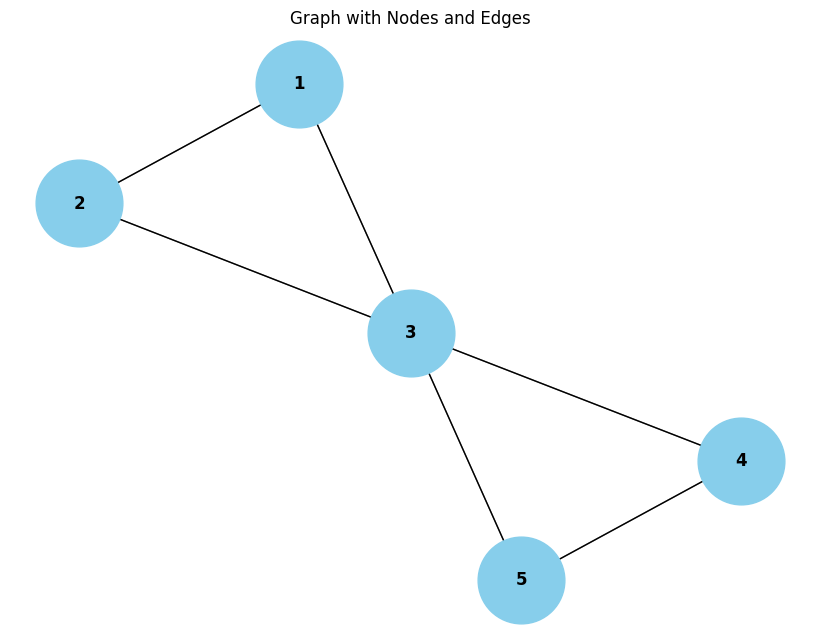

In [9]:
example_graph = {(1,2), (3,2), (3,1), (4,5), (4,3), (3,5)}
G = nx.Graph()
# Add nodes
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_node(5)

# Add edges
G.add_edge(1, 2)
G.add_edge(3, 2)
G.add_edge(3, 1)
G.add_edge(4, 5)
G.add_edge(4, 3)
G.add_edge(3, 5)

plt.figure(figsize=(8, 6))
# Draw the graph
pos = nx.spring_layout(G)  # Positions of the nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', font_weight='bold', node_size=3900, font_size=12)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='black')

# Show the graph
plt.title("Graph with Nodes and Edges")
plt.axis('off')  # Disable axis display
plt.show()

Here the algrithm correctly returns 2 as the number of triangles:

In [10]:
base = Triest_base(6)
print("The number of triangles are:", base.run(example_graph))

The number of triangles are: 2.0


With a more complicated graph:

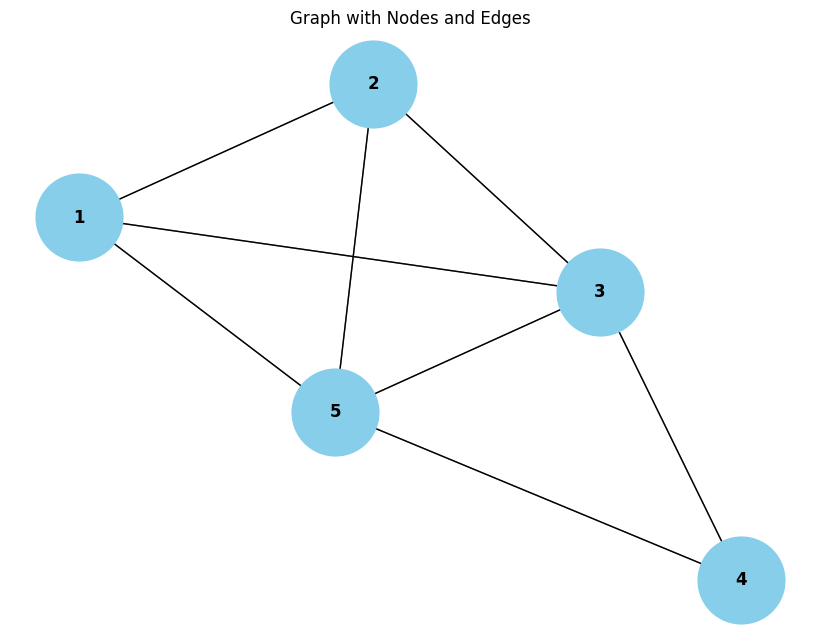

In [11]:
example_graph = {(1,2), (3,2), (3,1), (4,5), (4,3), (3,5), (2,5), (5,1)}
G = nx.Graph()
# Add nodes
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_node(5)

# Add edges
G.add_edge(1, 2)
G.add_edge(3, 2)
G.add_edge(3, 1)
G.add_edge(4, 5)
G.add_edge(4, 3)
G.add_edge(3, 5)
G.add_edge(2, 5)
G.add_edge(5, 1)

plt.figure(figsize=(8, 6))
# Draw the graph
pos = nx.spring_layout(G)  # Positions of the nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', font_weight='bold', node_size=3900, font_size=12)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='black')

# Show the graph
plt.title("Graph with Nodes and Edges")
plt.axis('off')  # Disable axis display
plt.show()

In this case the triangles are formed by:
- (1,2,3)
- (1,3,5)
- (3,4,5)
- (2,3,5)
- (1,2,5)

So, our algorithm should return 5.

In [12]:
base = Triest_base(8)
print("The number of triangles are:", base.run(example_graph))

The number of triangles are: 5.0


Now we can try the algorithm on the whole dataset of Facebook circles. As can be seen below, the number of triangles found is 1,612,010, which is coherent with the Dataset Statistics that can be found [here](https://snap.stanford.edu/data/ego-Facebook.html)

In [13]:
base = Triest_base(88234)
print("The estimated number of triangles estimated is:", base.run(edges))

t: 5000 tau: 274
t: 10000 tau: 2278
t: 15000 tau: 8049
t: 20000 tau: 18922
t: 25000 tau: 36458
t: 30000 tau: 62455
t: 35000 tau: 99816
t: 40000 tau: 150266
t: 45000 tau: 214230
t: 50000 tau: 293034
t: 55000 tau: 390699
t: 60000 tau: 508558
t: 65000 tau: 645308
t: 70000 tau: 807586
t: 75000 tau: 992401
t: 80000 tau: 1204671
t: 85000 tau: 1441069
The estimated number of triangles estimated is: 1612010.0


Now that we hev proved that our algorithm works properly, we can see how the estimation of triangles changes by modifying the M value, and therefore considering only a subset of M edges taken from the original set. In doing so, we can visualize how the estimation of number of global triangles found varies.
To get a clear picture of the estimation, we run the algorithm 10 times for each M, so that we can have a more accurate estimate.

In [14]:
M = [1000, 2500, 5000, 10000, 20000, 30000, 50000]
iterations = 10
all_estimations = []

for m in M:
  estimations = []
  for i in range(iterations):
    print(f"Running iteration {i} for M={m}...")
    base = Triest_base(m)
    estimation = base.run(edges)
    print("The estimated number of triangles estimated is:", estimation)
    estimations.append(estimation)
  all_estimations.append(estimations)

Running iteration 0 for M=1000...
t: 5000 tau: 2
t: 10000 tau: 0
t: 15000 tau: 3
t: 20000 tau: 1
t: 25000 tau: 1
t: 30000 tau: 2
t: 35000 tau: 3
t: 40000 tau: 2
t: 45000 tau: 3
t: 50000 tau: 5
t: 55000 tau: 4
t: 60000 tau: 5
t: 65000 tau: 5
t: 70000 tau: 6
t: 75000 tau: 5
t: 80000 tau: 5
t: 85000 tau: 4
The estimated number of triangles estimated is: 1377929.8353606192
Running iteration 1 for M=1000...
t: 5000 tau: 2
t: 10000 tau: 2
t: 15000 tau: 1
t: 20000 tau: 1
t: 25000 tau: 0
t: 30000 tau: 1
t: 35000 tau: 1
t: 40000 tau: 1
t: 45000 tau: 2
t: 50000 tau: 1
t: 55000 tau: 1
t: 60000 tau: 1
t: 65000 tau: 4
t: 70000 tau: 4
t: 75000 tau: 4
t: 80000 tau: 2
t: 85000 tau: 5
The estimated number of triangles estimated is: 2755859.6707212385
Running iteration 2 for M=1000...
t: 5000 tau: 5
t: 10000 tau: 6
t: 15000 tau: 1
t: 20000 tau: 0
t: 25000 tau: 4
t: 30000 tau: 2
t: 35000 tau: 3
t: 40000 tau: 3
t: 45000 tau: 3
t: 50000 tau: 3
t: 55000 tau: 2
t: 60000 tau: 0
t: 65000 tau: 1
t: 70000 tau: 1

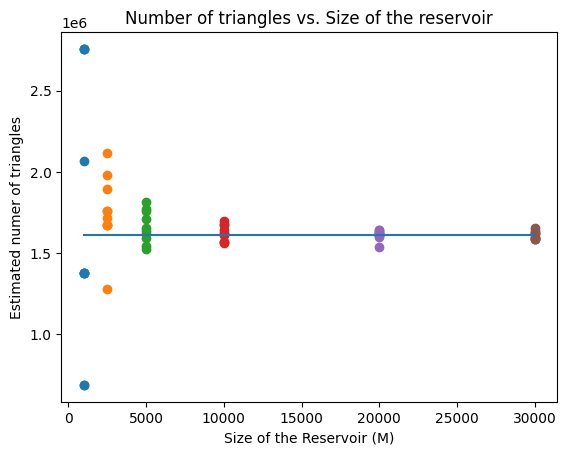

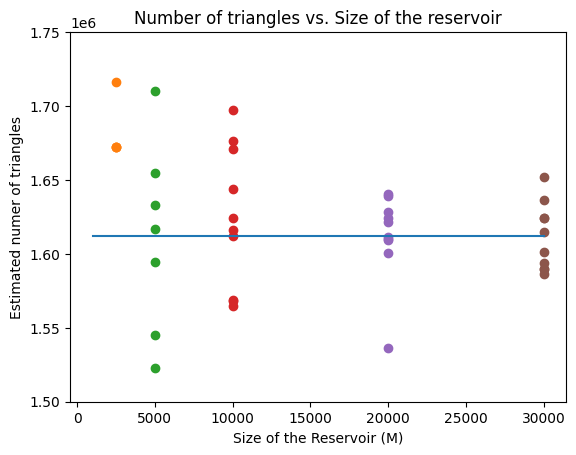

In [16]:
for i in range(6):
  plt.scatter([M[i]]*10, all_estimations[i])
plt.plot([1000, 30000], [1612010, 1612010])
plt.xlabel('Size of the Reservoir (M)')
plt.ylabel('Estimated numer of triangles')
plt.title('Number of triangles vs. Size of the reservoir')
plt.show()


for i in range(6):
  plt.scatter([M[i]]*10, all_estimations[i])
plt.plot([1000, 30000], [1612010, 1612010])
plt.xlabel('Size of the Reservoir (M)')
plt.ylabel('Estimated numer of triangles')
plt.title('Number of triangles vs. Size of the reservoir')
plt.ylim(15e5, 175e4)
plt.show()

We can see from the plots how increasing the value of M, the estimates get closer and closer to each other, becoming more accurate.

### Trièst Algorithm - Improved Version
Trièst Improved is a variant of Trièst Base with some small modifications that result in higher quality. Although the functions are very similar to the basic version, there are a few important changes:
- The function updateCounters is called unconditionally for each element on the stream, before the algorithm decides wether or not to insert the edge into S.
- Trièst Improved never decrements the counters when an edge is removed from S.
- updateCounters performs a weighted increase of the counters using η<sup>(t)</sup> = max{1, (t-1)(t-2)/(M(M-1))} as weight.
The class Triest_improved contains functions that are needed to run the improved version of the algorithm.

In [19]:
import random
import operator

class Triest_improved():
    def __init__(self, M):
        self.S = set()
        self.t = 0
        self.tau = 0
        self.tau_count = {}
        self.M = M

    def sampleEdge(self,edge):
        if self.t<=self.M:
            return True
        elif random.random() < (self.M / self.t):
            random_edge = random.choice(tuple(self.S))
            self.S.remove(random_edge)
            return True
        else:
            return False

    def updateCounters(self,operator,edge):
        u=edge[0]
        v=edge[1]

        common_neighbours = self.get_common_neighbours(edge)

        for c in common_neighbours:
            self.tau = operator(self.tau, max(1, ((self.t-1)*(self.t-2))/(self.M*(self.M-1))))
            self.tau_count[c] = operator(int(self.tau_count.get(c) or 0), max(1, ((self.t-1)*(self.t-2))/(self.M*(self.M-1))))
            self.tau_count[u] = operator(int(self.tau_count.get(u) or 0), max(1, ((self.t-1)*(self.t-2))/(self.M*(self.M-1))))
            self.tau_count[v] = operator(int(self.tau_count.get(v) or 0), max(1, ((self.t-1)*(self.t-2))/(self.M*(self.M-1))))

    def get_common_neighbours(self, edge):
        u=edge[0]
        v=edge[1]

        neighbours_u = set()
        neighbours_v = set()

        for elem in self.S:
            if u == elem[0]:
                neighbours_u.add(elem[1])
            if u == elem[1]:
                neighbours_u.add(elem[0])
            if v == elem[0]:
                neighbours_v.add(elem[1])
            if v == elem[1]:
                neighbours_v.add(elem[0])

        return neighbours_v & neighbours_u

    def run(self, dataset):
        for edge in dataset:
            #print(edge)
            self.t = self.t + 1
            self.updateCounters(operator.add,edge)
            if self.t % 5000 == 0:
                print("t:",self.t,"tau:",self.tau)
            if self.sampleEdge(edge):
                self.S.add(edge)
                #print(self.S)

        return self.tau

In [20]:
improved = Triest_improved(88234)
print("The estimated number of triangles estimated is:", improved.run(edges))

t: 5000 tau: 274
t: 10000 tau: 2278
t: 15000 tau: 8053
t: 20000 tau: 18928
t: 25000 tau: 36465
t: 30000 tau: 62467
t: 35000 tau: 99819
t: 40000 tau: 150272
t: 45000 tau: 214236
t: 50000 tau: 293038
t: 55000 tau: 390731
t: 60000 tau: 508561
t: 65000 tau: 645310
t: 70000 tau: 807642
t: 75000 tau: 992491
t: 80000 tau: 1204690
t: 85000 tau: 1441077
The estimated number of triangles estimated is: 1612010


Now that we have proved that also the improved algorithm works properly, we can check how the accuracy of the estimations changes with the improved version of the algorithm:

In [21]:
M = [1000, 2500, 5000, 10000, 20000, 30000, 50000]
iterations = 10
all_estimations = []

for m in M:
  estimations = []
  for i in range(iterations):
    print(f"Running iteration {i} for M={m}...")
    improved = Triest_improved(m)
    estimation = improved.run(edges)
    print("The estimated number of triangles estimated is:", estimation)
    estimations.append(estimation)
  all_estimations.append(estimations)

Running iteration 0 for M=1000...
t: 5000 tau: 330.79510510510505
t: 10000 tau: 2076.001175175175
t: 15000 tau: 8519.447237237237
t: 20000 tau: 20697.64472272272
t: 25000 tau: 40681.371261261265
t: 30000 tau: 69832.06649249246
t: 35000 tau: 106575.01689489484
t: 40000 tau: 157981.56530730726
t: 45000 tau: 219814.06324524517
t: 50000 tau: 296605.0604904903
t: 55000 tau: 425941.5237397396
t: 60000 tau: 523182.8220720722
t: 65000 tau: 698939.3655695696
t: 70000 tau: 840904.6694154154
t: 75000 tau: 1008514.0339019018
t: 80000 tau: 1210829.420054054
t: 85000 tau: 1362406.950034034
The estimated number of triangles estimated is: 1603791.5192652647
Running iteration 1 for M=1000...
t: 5000 tau: 336.7428548548549
t: 10000 tau: 1758.3275695695697
t: 15000 tau: 6334.135041041042
t: 20000 tau: 15404.57915915916
t: 25000 tau: 33485.55433833835
t: 30000 tau: 60445.655153153166
t: 35000 tau: 101699.14335935934
t: 40000 tau: 144770.30519919915
t: 45000 tau: 209784.74340740728
t: 50000 tau: 291946.752

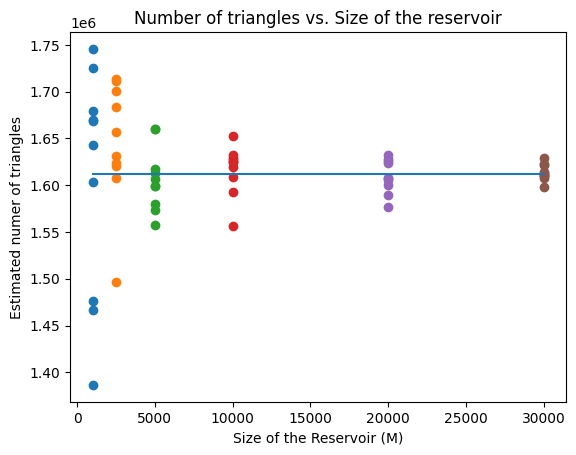

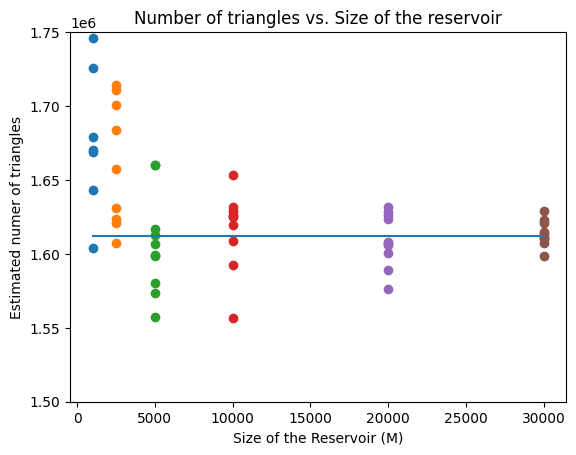

In [22]:
for i in range(6):
  plt.scatter([M[i]]*10, all_estimations[i])
plt.plot([1000, 30000], [1612010, 1612010])
plt.xlabel('Size of the Reservoir (M)')
plt.ylabel('Estimated numer of triangles')
plt.title('Number of triangles vs. Size of the reservoir')
plt.show()


for i in range(6):
  plt.scatter([M[i]]*10, all_estimations[i])
plt.plot([1000, 30000], [1612010, 1612010])
plt.xlabel('Size of the Reservoir (M)')
plt.ylabel('Estimated numer of triangles')
plt.title('Number of triangles vs. Size of the reservoir')
plt.ylim(15e5, 175e4)
plt.show()

As can be seen from the plots, as we increase the reservoir size (M), the produced estimates are more precise and less variant. Moreover, comparing the improved and the basic version of the Trièst algorithm, it is clear that the estimates produced by the improved algorithm are more precise, while the ones produced by the basic one are more variant and differ a lot among each other.

## Bonus Task
**1. What were the challenges you faced when implementing the algorithm?**
Implementing the Trièst algorithm was relatively straightforward due to the clarity of the paper and the well-defined pseudo-code provided. However, one crucial aspect was the careful selection of the dataset. Since the Trièst algorithm is designed for undirected graphs, the choice of dataset played a pivotal role. Ensuring that the dataset aligns with the algorithm's requirements was crucial for accurate implementation.

**2. Can the algorithm be easily parallelized? If yes, how? If not, why? Explain.**
Parallelizing the Trièst algorithm might be feasible, however it would necessitate substantial algorithmic modifications and synchronization among the processing units. Indeed, achieving parallel execution would require synchronization among workers to update both the local and global counters, given that this update process relies on the information about the neighbours at each step. This synchronization requirement poses a significant challenge, making the algorithm complex to parallelize effectively.

**3. Does the algorithm work for unbounded graph streams? Explain.**
The Trièst algorithm works properly with unbounded graph streams. By employing reservoir sampling, the algorithm maintains a fixed memory size (M). This fixed memory space ensures efficient utilization and prevents common issues such as memory under-utilization or overflow. This approach makes the Trièst algorithm suitable for unbounded streams while efficiently using available memory.

**4. Does the algorithm support edge deletions? If not, what modification would it need? Explain.**
The implemented Trièst algorithms only handle edge insertions and lack support for edge deletions. However, the paper introduces another algorithm, the Fully Dynamic algorithm, capable of handling both insertions and deletions through random paring. In this approach, edge deletions are compensated through subsequent edge insertions in the stream. The algorithm maintains counters to track uncompensated edge deletions, ensuring accuracy even with a mix of insertions and deletions in the graph.